# Lab 3: **Implementing Convolutional Neural Networks (CNNs)**
## Student **|** ID: **Percival Mahwaya | 41701**
## Subject: **Advanced AI Methods of AI**
## Department: **Applied Sciences	| Computer Science II (Data Scientist)**
## Professor: **dr in˙z. Godlove Kuaban**

# This lab is about implementing Convolutional Neural Networks (CNNs) in TensorFlow

I built and trained a CNN to classify images from the Fashion MNIST dataset.

Goals
- I loaded and preprocessed the Fashion MNIST.
- I implemented a CNN with convolution and pooling.
- I trained the model and tracked the training and validation metrics.
- I evaluated the test accuracy as per laboratory instructions.
- I visualised the learning curves and sample predictions.
- I interpreted the misclassifications and model behaviour.


# Theoretical background

Explaination of the main CNN ideas using short formulas and notes.


## Convolution operation

A convolution layer applied a learnable filter (kernel) over the input to produce a feature map.

Loss style equation (feature map)
$$
S(i,j) = (I * K)(i,j) = \sum_{m}\sum_{n} I(i+m, j+n)\,K(m,n)
$$

Where
- $I$ was the input image (or input feature map)
- $K$ was the filter (kernel)
- $S$ was the output feature map

Key ideas
- I used convolution to detect local patterns such as edges and textures.
- I learned kernel weights during training via backpropagation.

Stride
- I moved the kernel across the image using a step size.
- I reduced spatial size when I increased stride.

Padding
- I added border pixels around the input.
- I controlled output size and kept border information when I used padding.


## Local receptive fields

I used local receptive fields, where each neuron connected to a small region of the input instead of the full image.

What I gained
- I reduced the number of parameters compared to fully connected layers.
- I focused computation on local structure, which matched image data.


### Feature maps

Each filter produced one feature map.
Multiple filters produced multiple feature maps.

What I observed
- I learned different detectors in different channels, such as edge-like and texture-like responses.
- I increased representation power by stacking convolution layers and expanding the number of filters.


## Pooling operation

I reduced spatial dimensions while keeping strong activations.

Max pooling example
$$
p = \max_{(i,j)\in R} x_{i,j}
$$

Benefits I observed
- I reduced dimensionality and compute.
- I reduced sensitivity to small translations.
- I limited overfitting by compressing feature maps.


## Fully connected layers and softmax

I flattened convolution outputs into a vector and fed it into dense layers for classification.

Softmax function
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$$

Where
- $C$ was the number of classes
- $z_i$ was the logit for class $i$

What I produced
- I output probabilities across 10 Fashion MNIST classes.
# New Section

# Practical implementation steps

I followed these steps:
- I loaded Fashion MNIST from TensorFlow.
- I normalised pixel values to the range 0 to 1.
- I reshaped images to include a channel dimension (28, 28, 1).
- I encoded labels using one-hot encoding.
- I built a CNN with at least two convolution layers and max pooling.
- I trained for 10 epochs and logged metrics using TensorBoard.
- I evaluated test accuracy and visualised predictions.
- I inspected misclassifications and summarised what I observed.


In [2]:
# Imports
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models


In [3]:
# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [4]:
# Loading the Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [5]:
# Normalizing to 0..1
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Adding channel dimension: (28, 28) -> (28, 28, 1)
x_train = x_train[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

print("x_train reshaped:", x_train.shape)
print("x_test reshaped:", x_test.shape)


x_train reshaped: (60000, 28, 28, 1)
x_test reshaped: (10000, 28, 28, 1)


In [6]:
# One-hot encoding labels (TF option requested in the lab)
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes=10)

print("y_train one-hot:", y_train_oh.shape)
print("y_test one-hot:", y_test_oh.shape)


y_train one-hot: (60000, 10)
y_test one-hot: (10000, 10)


## Dataset and preprocessing

Dataset
- I used Fashion MNIST with 60,000 training images and 10,000 test images.
- Each image had shape \(28 \times 28\) in grayscale.

Preprocessing
- I scaled pixel values to the 0 to 1 range by dividing by 255.
- I reshaped images from \((28, 28)\) to \((28, 28, 1)\) to include the channel dimension.
- I converted labels to one-hot vectors with 10 classes.

Shapes I worked with
- Training images: (60000, 28, 28, 1)
- Test images: (10000, 28, 28, 1)
- Training labels (one-hot): (60000, 10)
- Test labels (one-hot): (10000, 10)


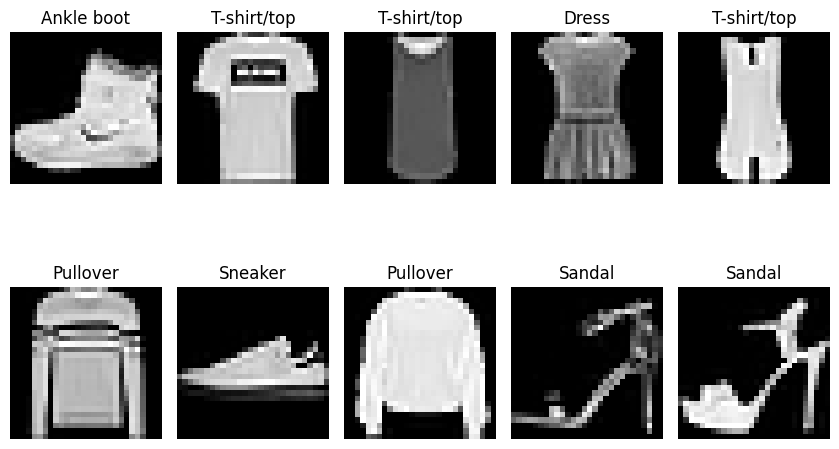

In [19]:
# Visualising a few training samples
plt.figure(figsize=(8.5, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap="gray")
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [9]:
# Building a CNN model (2+ conv layers, max pooling, dense, softmax)
cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")
])

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,162 (1004.54 KB)

 Trainable params: 257,162 (1004.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compiling the model
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
# TensorBoard logging
log_dir = os.path.join("logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print("TensorBoard log_dir:", log_dir)


TensorBoard log_dir: logs/fit/20260114-154924


In [12]:
# TensorBoard logging
log_dir = os.path.join("logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print("TensorBoard log_dir:", log_dir)


TensorBoard log_dir: logs/fit/20260114-155020


In [13]:
# Training the model
history = cnn_model.fit(
    x_train, y_train_oh,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    callbacks=[tensorboard_cb],
    verbose=1
)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 87s 200ms/step - accuracy: 0.6739 - loss: 0.8951 - val_accuracy: 0.8637 - val_loss: 0.3563
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 193ms/step - accuracy: 0.8616 - loss: 0.3962 - val_accuracy: 0.8887 - val_loss: 0.2987
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 194ms/step - accuracy: 0.8855 - loss: 0.3247 - val_accuracy: 0.8988 - val_loss: 0.2699
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - accuracy: 0.8982 - loss: 0.2897 - val_accuracy: 0.9105 - val_loss: 0.2530
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 194ms/step - accuracy: 0.9067 - loss: 0.2624 - val_accuracy: 0.9103 - val_loss: 0.2471
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 192ms/step - accuracy: 0.9122 - loss: 0.2424 - val_accuracy: 0.9078 - val_loss: 0.2540
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 86s 204ms/step - accuracy: 0.9169 - loss: 0.2267 - val_accuracy: 0.9162 - val_loss: 0.2307
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - accuracy: 0.9252 - loss: 

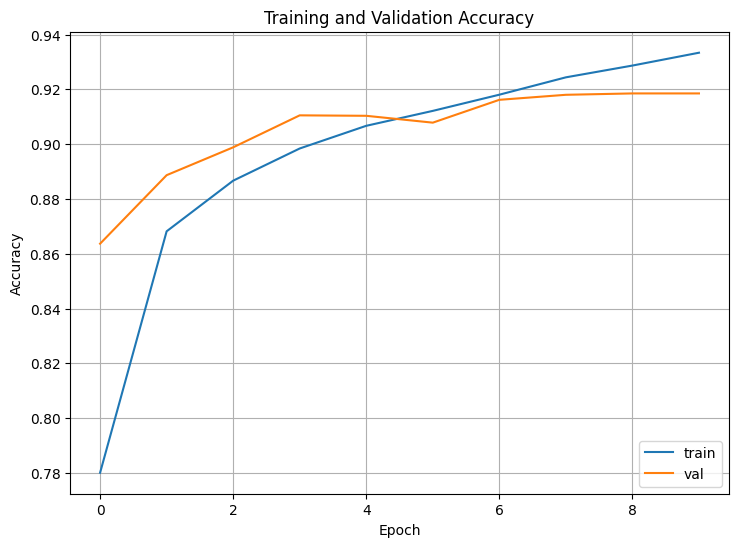

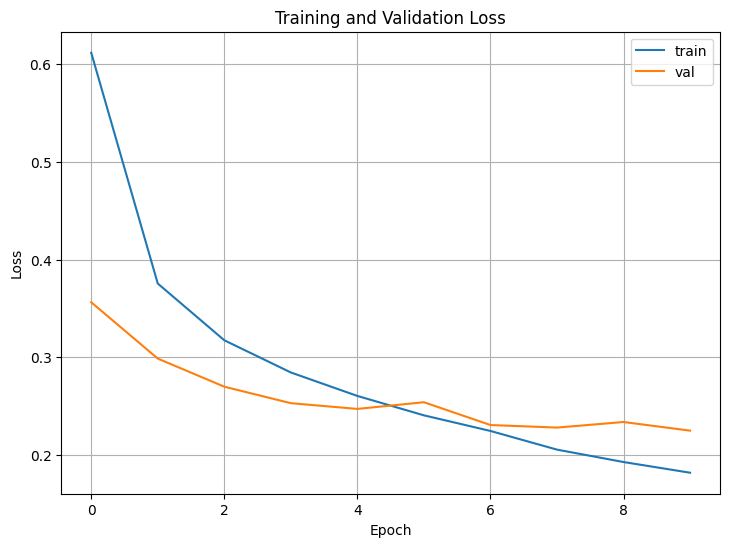

In [20]:
# Plotting training and validation curves
plt.figure(figsize=(8.5, 6))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"], loc="lower right")
plt.grid(True)
plt.show()

plt.figure(figsize=(8.5, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"], loc="upper right")
plt.grid(True)
plt.show()


In [15]:
# Evaluating on test set
test_loss, test_acc = cnn_model.evaluate(x_test, y_test_oh, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Test loss: 0.2527
Test accuracy: 0.9135


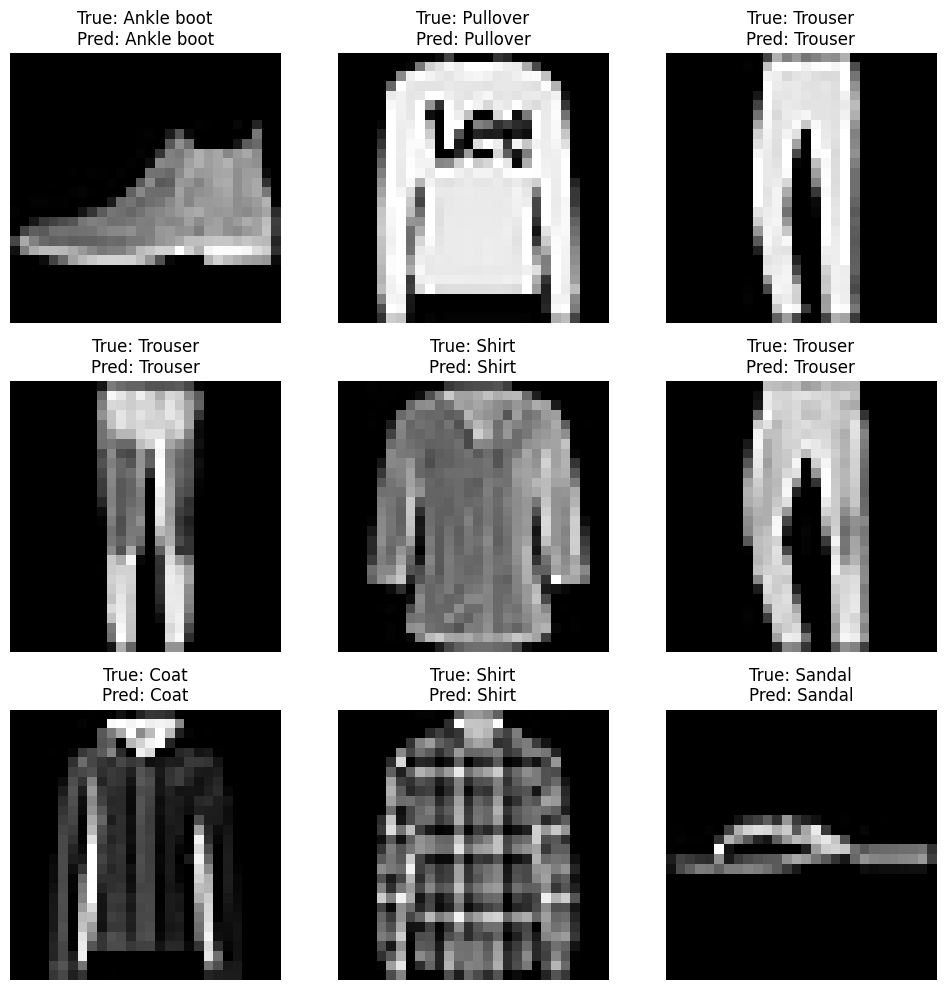

In [16]:
# Predictions
probs = cnn_model.predict(x_test, verbose=0)
y_pred = np.argmax(probs, axis=1)

# Visualising at least 9 test images with predicted vs true labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    true_label = class_names[y_test[i]]
    pred_label = class_names[y_pred[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Misclassifications: 865


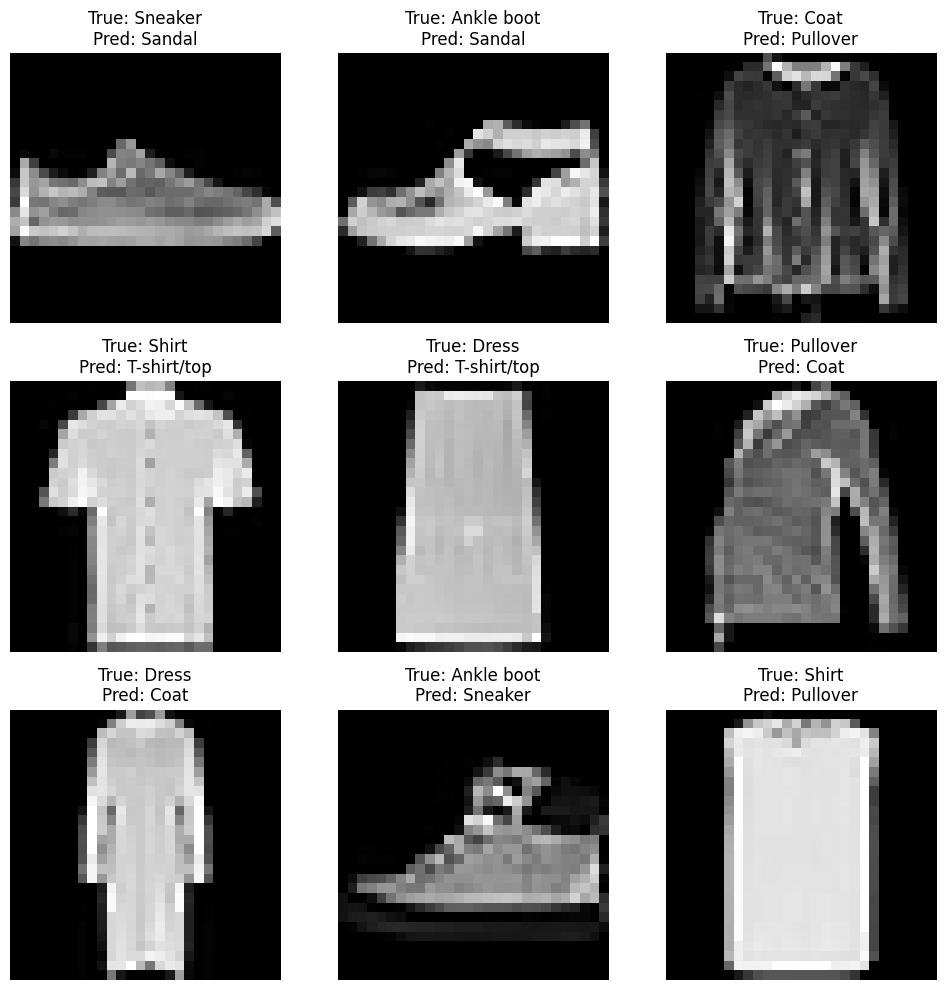

In [17]:
# Showing some misclassifications
mis_idx = np.where(y_pred != y_test)[0]
print("Misclassifications:", len(mis_idx))

plt.figure(figsize=(10, 10))
for i in range(min(9, len(mis_idx))):
    idx = mis_idx[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap="gray")
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()


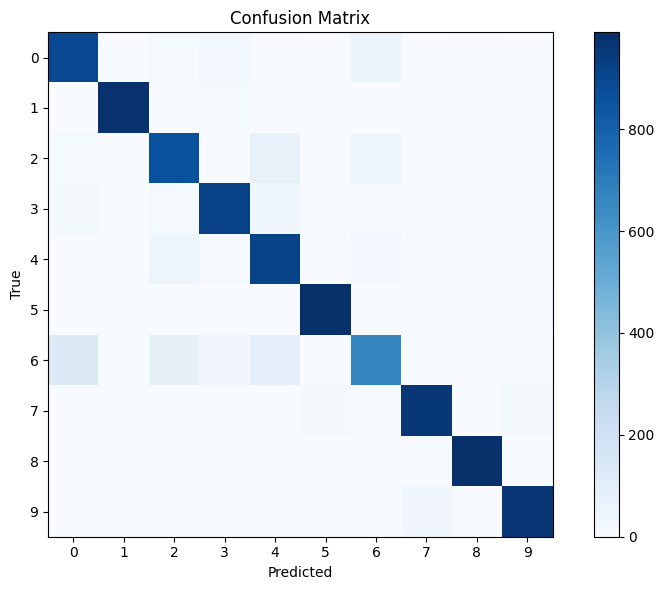

In [21]:
# Confusion matrix
cm = tf.math.confusion_matrix(y_test, y_pred, num_classes=10).numpy()

plt.figure(figsize=(8.5, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10), range(10))
plt.yticks(range(10), range(10))
plt.tight_layout()
plt.show()


# TensorBoard visualisation

I logged training metrics into the `logs` folder.

In Colab, I ran:
- `%load_ext tensorboard`
- `%tensorboard --logdir logs`

What I checked in TensorBoard
- Scalars: I reviewed loss and accuracy for training and validation.
- Graphs: I inspected the computation graph.
- Histograms: I tracked weight and bias distributions during training.


## Model architecture and training setup

CNN architecture
- I used Conv2D and MaxPooling blocks to extract features.
- I used a Dense layer for classification after flattening.
- I added Dropout to reduce overfitting.

Training setup
- I compiled the model with Adam optimizer.
- I used categorical cross-entropy loss for multi-class classification.
- I tracked accuracy during training.
- I trained for 10 epochs with a validation split of 0.1.
- I logged training with TensorBoard for metrics tracking.


## Learning curves interpretation

What I saw in the curves
- Training accuracy increased steadily and ended near 0.93.
- Validation accuracy increased and stabilised near 0.92.
- Training loss dropped sharply early and then decreased slowly.
- Validation loss followed the same pattern and stayed close to training loss.

What I concluded from the curves
- I saw a small gap between training and validation accuracy.
- I saw no strong overfitting signal within 10 epochs.
- I saw stable optimisation, with no divergence or oscillation.


## Test evaluation and sample predictions

Test results
- I evaluated the model on the test set.
- I recorded test loss = 0.2527.
- I recorded test accuracy = 0.9135.

Sample predictions
- I displayed a grid of test images with predicted and true labels.
- I observed many correct matches between true and predicted classes in the sample grid.


## Misclassifications and confusion matrix

Misclassifications I inspected
- I found errors concentrated in visually similar classes.
- I saw Sneaker predicted as Sandal.
- I saw Ankle boot predicted as Sneaker or Sandal.
- I saw Shirt predicted as T-shirt/top or Pullover.
- I saw Dress predicted as Coat or T-shirt/top.
- I saw Coat predicted as Pullover.

Confusion matrix summary
- I plotted a 10x10 confusion matrix.
- I observed a strong diagonal, which matched the high test accuracy.
- I observed lighter off-diagonal cells in similar clothing groups, which matched the misclassification examples.


## Conclusion

I built and trained a CNN for Fashion MNIST classification in TensorFlow.
I achieved about 0.91 test accuracy with stable learning curves.
I observed most errors in pairs of classes with similar shapes and textures.
I used convolution and pooling to extract local patterns and reduce spatial size.
I used dropout to limit overfitting and improve generalisation.
